# Integration of a multivariate function

The first example is taken from Ref. [[1]](#References) and shows the most obvious application of TCI, the calculation of an N-dimensional integral.
For definiteness, we consider a toy example from Ref. [[2]](#References) for which the result is known analytically: the computation of the following integral over a hypercube:

$$
    I^{(\mathcal{N})} =  \int_{[0,1]^\mathcal{N}} dx_1 \ldots dx_\mathcal{N} 
    f(\mathbf{x}) 
    , \qquad 
    f(\mathbf{x}) =
    \frac{2^\mathcal{N}}{1 + 2 \sum^\mathcal{N}_{\ell=1} x_\ell} .
$$

For $\mathcal{N}=5$, the analytical solution of above integral is

$$
  I^{(5)} =   [- 65205 \log(3) - 6250 \log(5) + 24010 \log(7) + 14641 \log(11)] / 24.
$$

The first line in the following code block imports the packages xfacpy as well as standard Python packages for numerical computations and plotting (lines 3-5).

In [6]:
import xfacpy

import numpy as np
from math import log
import matplotlib.pyplot as plt

In the next lines of the following code block, the dimension $\mathcal{N}=5$ and the user-supplied function `f` are defined. Line 4 defines an (optional) attribute of `f`, `neval`, counting the number of times the integrand is called; line 5 defines the integrand. Here x is a list of floats or a numpy array. For each argument $x_\ell$, the user specifies a grid $\{x_\ell(\sigma_\ell)\}$
of $d_\ell$ quadrature nodes, enumerated by an index $\sigma_\ell$, and an associated grid of quadrature weights 
$\{w_\ell(\sigma_\ell)\}$. 
Here, we use the nodes and weights of the Gauss-Kronrod quadrature, with $d_\ell=15$ for all $\ell$. 
For convenience, the Gauss-Kronrod quadrature is included in `xfac` so that the `xfacpy.GK15()` function in line 13 returns two lists, `xell` and `well`, containing the 
quadrature nodes $\{x_\ell(\sigma_\ell)\}$ 
and weights $\{w_\ell (\sigma_\ell)\}$, 
respectively (chosen the same for all $\ell$).

In [7]:
N = 5  # Number of dimensions

def f(x):  # Integrand function
    f.neval += 1
    return 2**N / (1 + 2 * sum(x))

f.neval = 0

# Exact integral value in 5 dimensions
i5 = (- 65205 * log(3) - 6250 * log(5) + 24010 * log(7) + 14641 * log(11)) / 24

# Gauss-Kronrod abscissas (xell) and weights (well)
xell, well = xfacpy.GK15(0, 1)

The `CTensorCI()` object is created in line 2 of the following code block and is the basic object used to perform TCI on a continuous function, discretized as $F_\sigma = f\bigl(\mathbf{x}(\sigma)\bigr)$. This class performs the factorization in Accumulative mode.
Note that `CTensorCI()}` is a thin wrapper over the corresponding discrete class `TensorCI()` that
creates $F_\sigma$ from $f(\mathbf{x})$ and the grids $\mathbf{x}_\ell(\sigma_\ell)$.
To instantiate the class, two arguments must be provided: the function 
`f`, and the grid on which the function will be called,
`[xell] * N}`. 
 For $\mathcal{N}=5$, the latter is equivalent to 
`[xell, xell, xell, xell, xell]`, i.e. five copies
of the GK15 grid (a list of list of points). 

The loop in lines 9-12 performs a series of half-sweeps, 
alternating left-to-right and right-to-left, to iteratively improve the TCI approximation  $\tilde{F}_\sigma$ of the tensor $F_\sigma$.
In line 10, `tci.iterate()` performs one half-sweep,
and in line 11, `tci.sumWeighted([well] * N)` calculates the integral. 

In [8]:
# TCI1 Tensor factorization, no environment
tci = xfacpy.CTensorCI1(f, [xell] * N)

# Estimate integral and error
itci = []
nevals = []

hsweeps = range(1, 15)
for hsweep in hsweeps:
    tci.iterate()
    itci.append(tci.get_TensorTrain().sum([well] * N))
    nevals.append(f.neval)

Finally, the next code block plots the results. The left figure shows the relative error for the integral $|1 - I^{(5)}/\tilde{I}^{(5)} |$ (blue solid lines with circles),  and the relative in-sample error $|1 - F_\sigma/\tilde{F}_\sigma|_\mathrm{max}$ (yellow dashed lines with crosses) plotted against the number of half-sweeps. The right figure shows the corresponding number of calls to the integrand function $f$ vs. the number of half-sweeps.

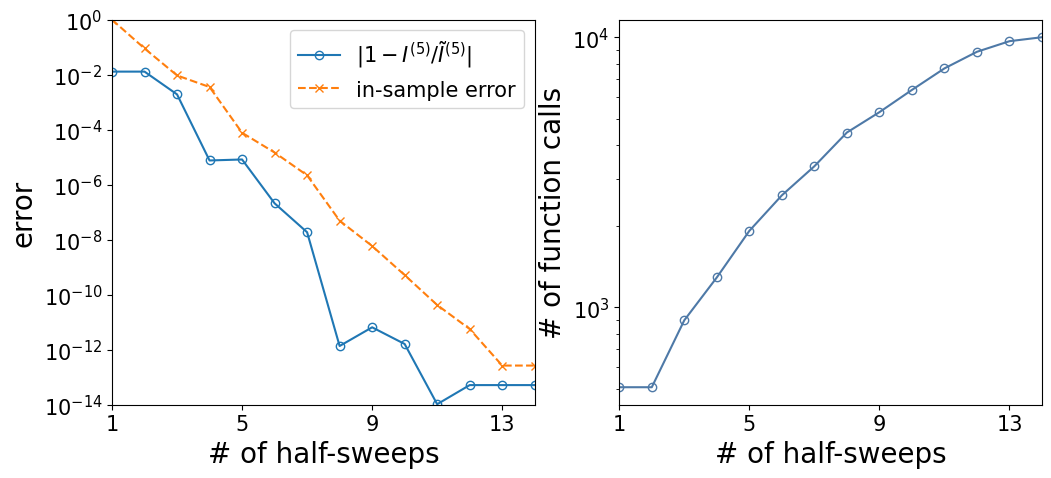

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(hsweeps, abs(1 - np.array(itci) / i5), '-o', markerfacecolor='none', label=r"$|1 - I^{(5)} / \tilde{I}^{(5)}|$")
axes[0].plot(hsweeps, np.array(tci.pivotError) / tci.pivotError[0], '--x', label=r"in-sample error")
axes[1].plot(hsweeps, nevals, '-o', markerfacecolor='none', color='#4e79a7')

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(1, 14)
    ax.set_xticks(range(1, 14, 4))
    ax.set_xlabel(r'# of half-sweeps', size=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

axes[0].set_ylim(1e-14, 1)
axes[0].legend(prop={'size': 15})

axes[0].set_ylabel(r'error', size=20)
axes[1].set_ylabel(r'# of function calls', size=20)
plt.show()

## References

[1] Yuriel Núñez Fernández, Marc K. Ritter, Matthieu Jeannin, Jheng-Wei Li, Thomas Kloss, Olivier Parcollet, Jan von Delft, Hiroshi Shinaoka, and Xavier Waintal, *Learning low-rank tensor train representations: new algorithms and libraries*, *in preparation*, (2024).

[2] J. Burkardt, __[Test_nint, multi-dimensional integration test functions](https://people.math.sc.edu/Burkardt/f_src/test_nint/test_nint.html)__ .